## Importing libraries

For any issues running these modules, use python -m pip install -r requirements.txt

In [282]:
import pandas as pd
import numpy as np
import yfinance as yf
import sklearn
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Data Visualization

Visualize the data that we have extracted to better understand trends to expect and routes to go for changing parameters.

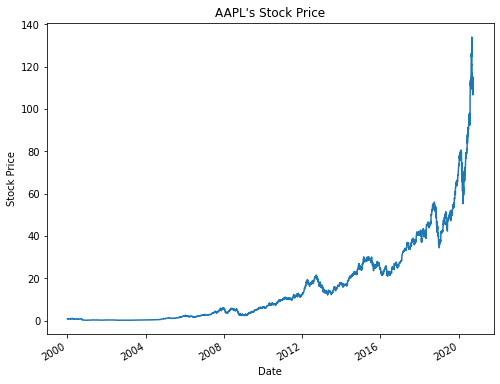

In [283]:
# Quarterly history of Tablular data:
def cleanHist(hist):
    clean_hist = hist.copy()
    for index, row in hist.iterrows():
        if np.isnan(row['Open']):
            clean_hist = clean_hist.drop(index)
    return clean_hist

# Converts timestamp object to nice-looking date
def convertTimeStamp(timestamp):
    return str(timestamp)[5:7] + "/" + str(timestamp)[:4]

def getDates(index):
    return [convertTimeStamp(timestamp) for timestamp in index]

apple = yf.Ticker("AAPL")
hist = apple.history(start="2000-01-01", end="2020-09-30", actions=False)
quarterly_hist = apple.history(start="2000-01-01", end="2020-09-30", interval="3mo", actions=False)
quarterly_percent = (quarterly_hist["Close"]-quarterly_hist["Open"])/quarterly_hist["Open"]*100
quarterly_hist["%Increase"] = quarterly_percent
quarterly_hist = cleanHist(quarterly_hist)

# Table of quarterly data
fig = go.Figure(data=[go.Table(
    header=dict(values=['Date'] + list(quarterly_hist.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[getDates(quarterly_hist.index), round(quarterly_hist['Open'], 4),
                       round(quarterly_hist['High'], 4), round(quarterly_hist['Low'], 4),
                       round(quarterly_hist['Close'], 4), quarterly_hist['Volume'],
                       round(quarterly_hist['%Increase'], 4)],
               fill_color='lavender',
               align='center'))
])

fig.show()

# AAPL Stock Price
fig = plt.figure(figsize=(8, 14))
ax1 = fig.add_subplot(211)
ax1.set_title('AAPL\'s Stock Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price')
hist["Close"].plot()
plt.show()

# AAPL Bar Chart
bar_chart = {
    'x': hist.index,
    'open': hist.Open,
    'close': hist.Close,
    'high': hist.High,
    'low': hist.Low,
    'type': 'candlestick',
    'name': 'AAPL',
    'showlegend': True
}

pio.show(bar_chart)


# Data Extraction 

In [284]:
apple = yf.Ticker("AAPL")
hist = apple.history(start="2000-01-03", end="2020-09-30", actions=False) # 2000-01-03 is Monday.

# Stacked LSTM Model

#### Data preparation

In [285]:
hist=hist.reset_index()
hist=hist.loc[:,'Close']
hist=pd.DataFrame(hist)

#### Data Transformation

In [286]:
training_window=10
forward_window=1
x=[]
y=[]
counter=0
for i in range(0,hist.shape[0]-forward_window-training_window+1,forward_window):
    x.append(np.array(hist.iloc[i:(i+training_window),0]).reshape(training_window,1))
    y.append(np.array(hist.iloc[(i+training_window):(i+training_window+forward_window),0]))

x_train=np.array(x[:4000])
y_train=np.array(y[:4000])
x_test=np.array(x[4000:])
y_test=np.array(y[4000:])

#### Model Architecture

In [287]:
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout,Activation
from keras.layers import Bidirectional
import tensorflow as tf

model=Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(training_window,1)))
model.add(LSTM(25,activation='relu'))
# model.add(Dense(10,activation='linear'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])

#### Model Training

In [288]:
history = model.fit(x_train,y_train,batch_size=5,epochs=100,validation_split=0.2, verbose=False)

#### Training History

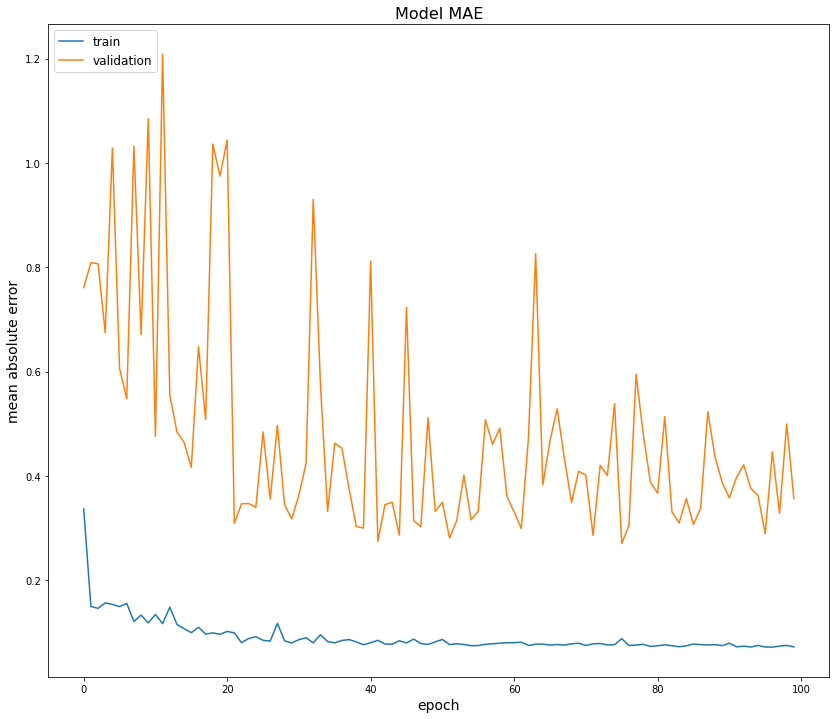

In [289]:
# summarize history for MAE
plt.figure(figsize=(14,12))
plt.title('Stacked LSTM Model MAE',fontsize='16')
plt.ylabel('mean absolute error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['train', 'validation'], loc='upper left', fontsize='large')
plt.show()

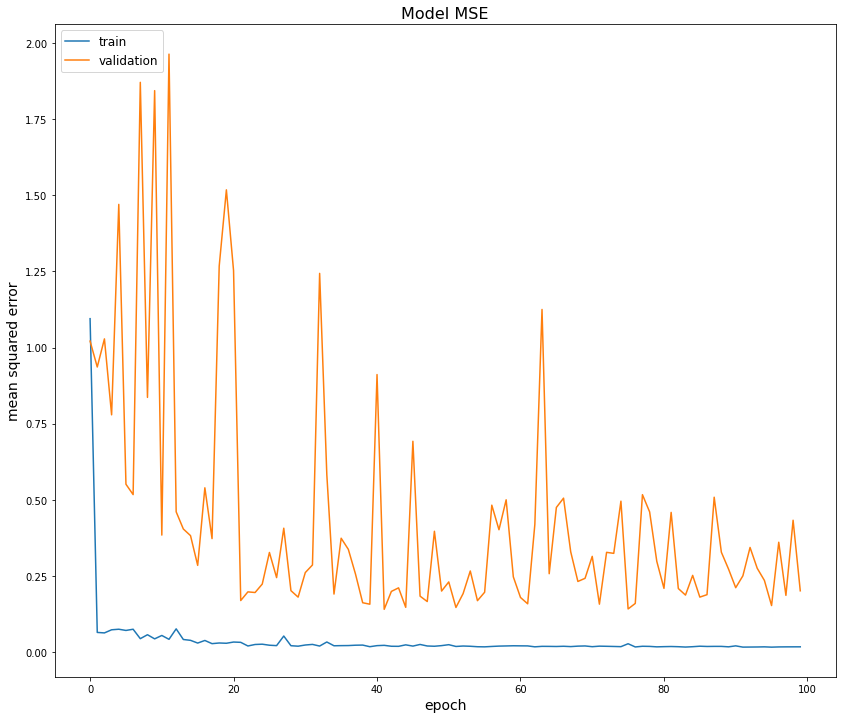

In [290]:
# summarize history for MSE
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Stacked LSTM Model MSE',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['train', 'validation'], loc='upper left', fontsize='large')
plt.show()

#### Model Testing

In [291]:
predicted=model.predict(x_test)

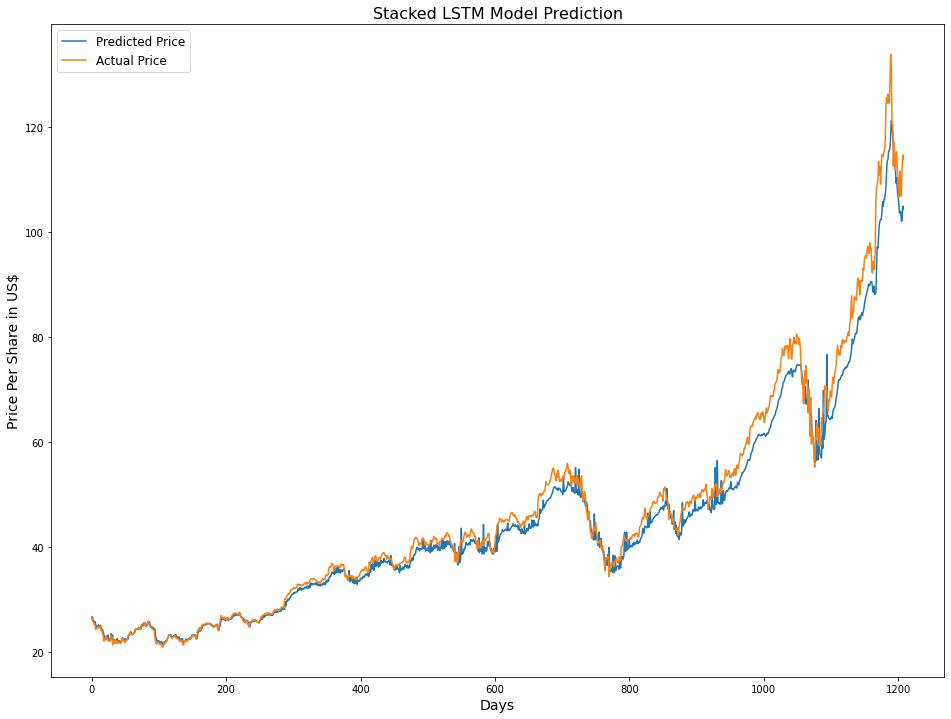

In [292]:
plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax = fig.add_axes([0.1, 0.1, 2.3, 3.5])
plt.xlabel('Days',fontsize='14')
plt.ylabel('Price Per Share in US$',fontsize='14')
plt.title('Stacked LSTM Model Prediction',fontsize='16')
pred, = plt.plot([i for i in range(len(hist[4000:])-training_window)], predicted.flatten())
actual, = plt.plot([i for i in range(len(hist[4000+training_window:]))], hist[4000+training_window:])
plt.legend([pred, actual], ['Predicted Price', 'Actual Price'], loc='upper left', fontsize='large')
plt.show()

In [293]:
from sklearn.metrics import mean_squared_error
mean_squared_error(predicted,y_test)

10.34655855292903

# CNN-LSTM Model

#### Data Pre-processing

In [294]:
hist=hist.reset_index()
hist=hist.loc[:,'Close']
hist=pd.DataFrame(hist)

#### Data Transformation

In [295]:
training_window=20
forward_window=1
x=[]
y=[]
counter=0
for i in range(0,hist.shape[0]-forward_window-training_window+1,forward_window):
    x.append(np.array(hist.iloc[i:(i+training_window),0]))
    y.append(np.array(hist.iloc[(i+training_window):(i+training_window+forward_window),0]))

x_train=np.array(x[:4000])
y_train=np.array(y[:4000])
x_test=np.array(x[4000:])
y_test=np.array(y[4000:])
x_train=x_train.reshape((x_train.shape[0],2,10,1))
x_test=x_test.reshape((x_test.shape[0],2,10,1))

#### Model Architecture

In [296]:
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout,Activation
import tensorflow as tf
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, 10, 1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])

#### Model Training

In [297]:
history = model.fit(x_train,y_train,epochs=200,validation_split=0.2, verbose=False)
#model.fit(x_train,y_train,batch_size=5,epochs=10,validation_split=0.2)

#### Training History

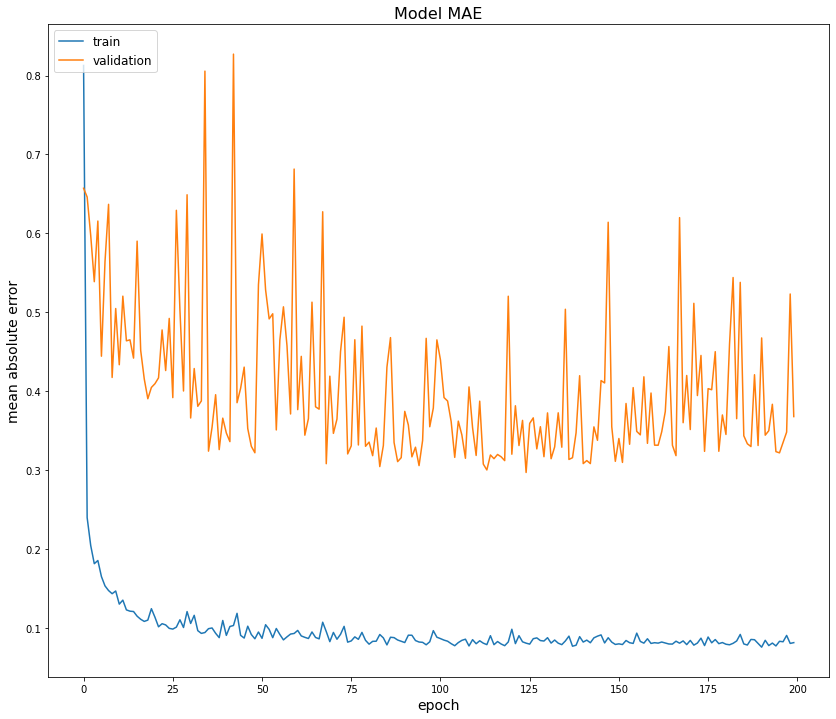

In [298]:
# summarize history for MAE
plt.figure(figsize=(14,12))
plt.title('CNN-LSTM Model MAE',fontsize='16')
plt.ylabel('mean absolute error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['train', 'validation'], loc='upper left', fontsize='large')
plt.show()

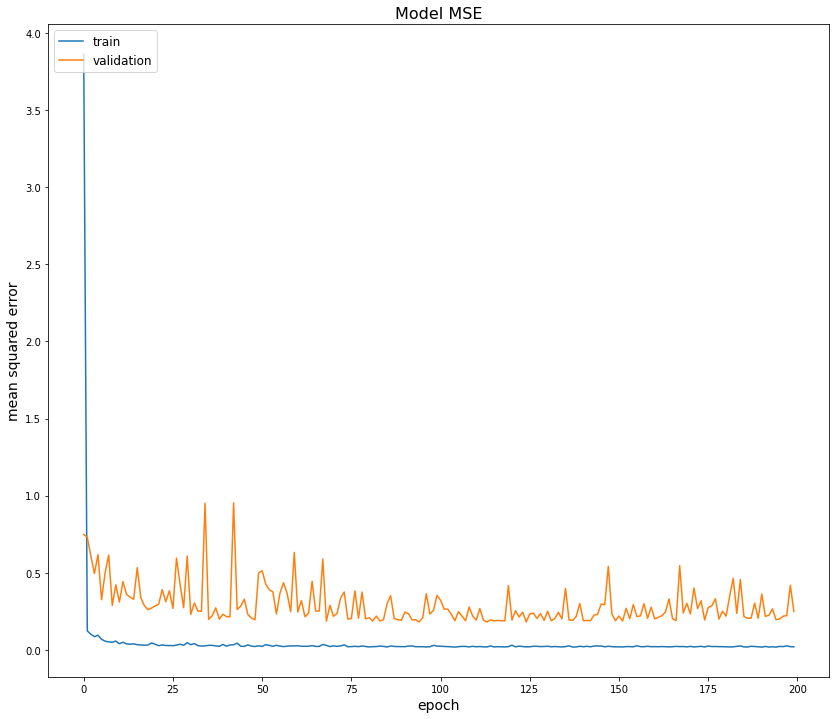

In [299]:
# summarize history for MSE
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN-LSTM Model MSE',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['train', 'validation'], loc='upper left', fontsize='large')
plt.show()

#### Model Testing

In [300]:
predicted=model.predict(x_test)

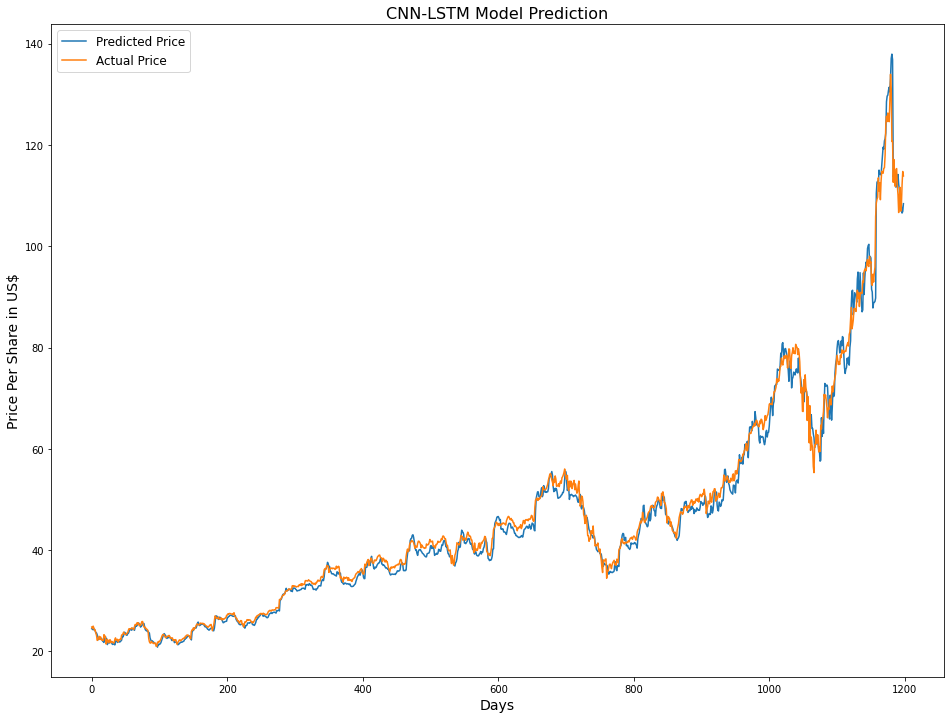

In [301]:
plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax = fig.add_axes([0.1, 0.1, 2.3, 3.5])
plt.xlabel('Days',fontsize='14')
plt.ylabel('Price Per Share in US$',fontsize='14')
plt.title('CNN-LSTM Model Prediction',fontsize='16')
pred, = plt.plot([i for i in range(len(hist[4000:])-training_window)], predicted.flatten())
actual, = plt.plot([i for i in range(len(hist[4000+training_window:]))], hist[4000+training_window:])
plt.legend([pred, actual], ['Predicted Price', 'Actual Price'], loc='upper left', fontsize='large')
plt.show()

In [302]:
from sklearn.metrics import mean_squared_error
mean_squared_error(predicted,y_test)

4.054179200334808

In [303]:
model.save('MSE2.00')

INFO:tensorflow:Assets written to: MSE2.00/assets


# Multi-variate LSTM

#### Data Preprocessing

In [304]:
hist=hist.reset_index()
hist=hist.loc[:,'Close']
hist=pd.DataFrame(hist)

#### Engineering of New Fields

In [305]:
hist['SMA_10']=hist['Close'].rolling(10).mean().shift()
#hist['SMA_20']=hist['Close'].rolling(20).mean().shift()

multiplier10=2 / (10 + 1)
#multiplier20=2 / (20 + 1)
hist['EMA_10']=np.nan
#hist['EMA_20']=np.nan
hist.loc[10,'EMA_10']=hist.loc[10,'SMA_10']
#hist.loc[20,'EMA_20']=hist.loc[20,'SMA_20']

for i in range(11,hist.shape[0]):
    hist.loc[i,'EMA_10']=(hist.loc[i,'Close']*multiplier10)+(hist.loc[i-1,'EMA_10']*(1-multiplier10))
#     if i >20:
#         hist.loc[i,'EMA_20']=(hist.loc[i,'Close']*multiplier20)+(hist.loc[i-1,'EMA_20']*(1-multiplier20))

hist['STD_10']=hist['Close'].rolling(10).std().shift()
#hist['STD_20']=hist['Close'].rolling(20).std().shift()

hist['BB_Bandwidth10']=2*1.5*hist['STD_10']

hist=hist.dropna(axis=0)

hist=hist.drop(columns=['SMA_10','STD_10']).reset_index()

hist=hist.drop(columns=['index'])

#### Feature Scaling

In [306]:
from sklearn.preprocessing import MinMaxScaler
columns=hist.columns
scaler=MinMaxScaler()
train=scaler.fit_transform(hist.iloc[:4000,:])
train=pd.DataFrame(train,columns=columns)
test=scaler.transform(hist.iloc[4000:,:])
test=pd.DataFrame(test,columns=columns)

#### Data Transformation

In [307]:
close_train=hist['Close'].tolist()[:4000]
close_test=hist['Close'].tolist()[4000:]
training_window=20
forward_window=1
x=[]
y=[]
counter=0
for i in range(0,train.shape[0]-forward_window-training_window+1,forward_window):
    x.append(np.array(hist.iloc[i:(i+training_window),:]))
    y.append(np.array(close_train[(i+training_window):(i+training_window+forward_window)]))
x_train=np.array(x)
y_train=np.array(y)
x=[]
y=[]
for i in range(0,test.shape[0]-forward_window-training_window+1,forward_window):
    x.append(np.array(test.iloc[i:(i+training_window),:]))
    y.append(np.array(close_test[(i+training_window):(i+training_window+forward_window)]))
x_test=np.array(x)
y_test=np.array(y)

In [308]:
#x_train=x_train.reshape((x_train.shape[0], 2, 10, 3))
#x_test=x_test.reshape((x_test.shape[0], 2, 10, 3))


#### Model Architecture

In [309]:
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout,Activation
import tensorflow as tf
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import BatchNormalization

# model = Sequential()
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'), input_shape=(None, 10, 3)))
# model.add(BatchNormalization())
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(100, activation='relu'))
# model.add(Dense(1,activation='linear'))
# model.compile(optimizer='adam', loss='mse')

model=Sequential()
model.add(LSTM(150,activation='relu',return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(75,activation='relu'))
# model.add(Dense(10,activation='linear'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_absolute_error'])

#### Model Training

In [310]:
model.fit(x_train,y_train,batch_size=64,epochs=200,validation_split=0.2, verbose=False, callbacks=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=30,
    restore_best_weights=True,
))

#### Training History

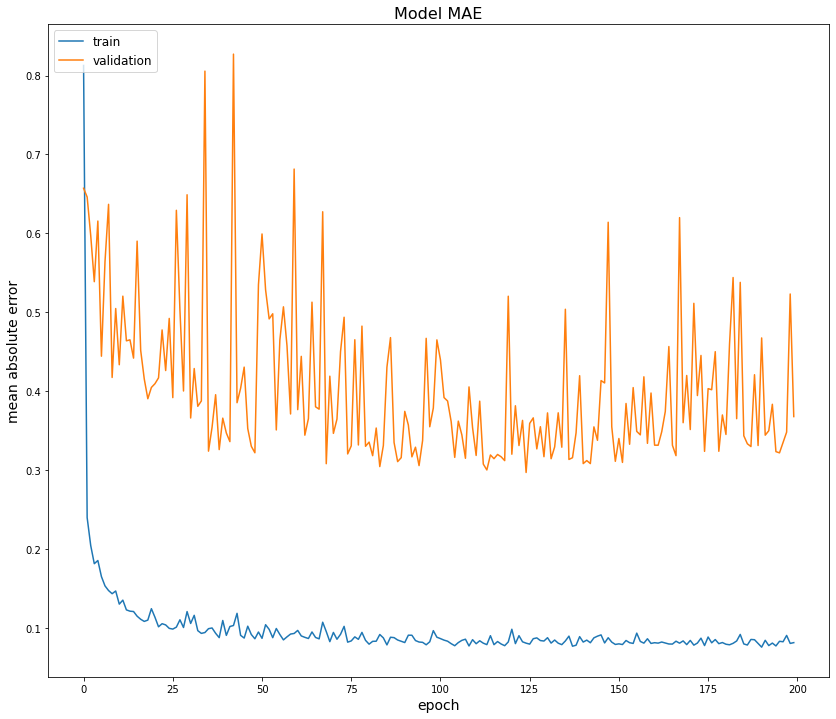

In [311]:
# summarize history for MAE
plt.figure(figsize=(14,12))
plt.title('Multi-variate LSTM Model MAE',fontsize='16')
plt.ylabel('mean absolute error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['train', 'validation'], loc='upper left', fontsize='large')
plt.show()

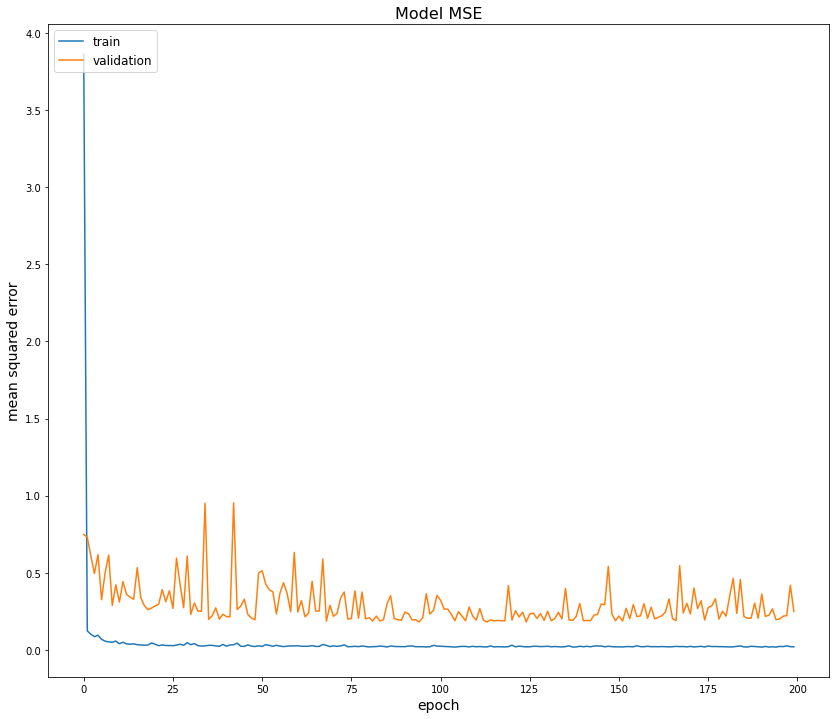

In [312]:
# summarize history for MSE
plt.figure(figsize=(14,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Multi-variate LSTM Model MSE',fontsize='16')
plt.ylabel('mean squared error',fontsize='14')
plt.xlabel('epoch',fontsize='14')
plt.legend(['train', 'validation'], loc='upper left', fontsize='large')
plt.show()

#### Model Testing

In [313]:
predicted=model.predict(x_test)

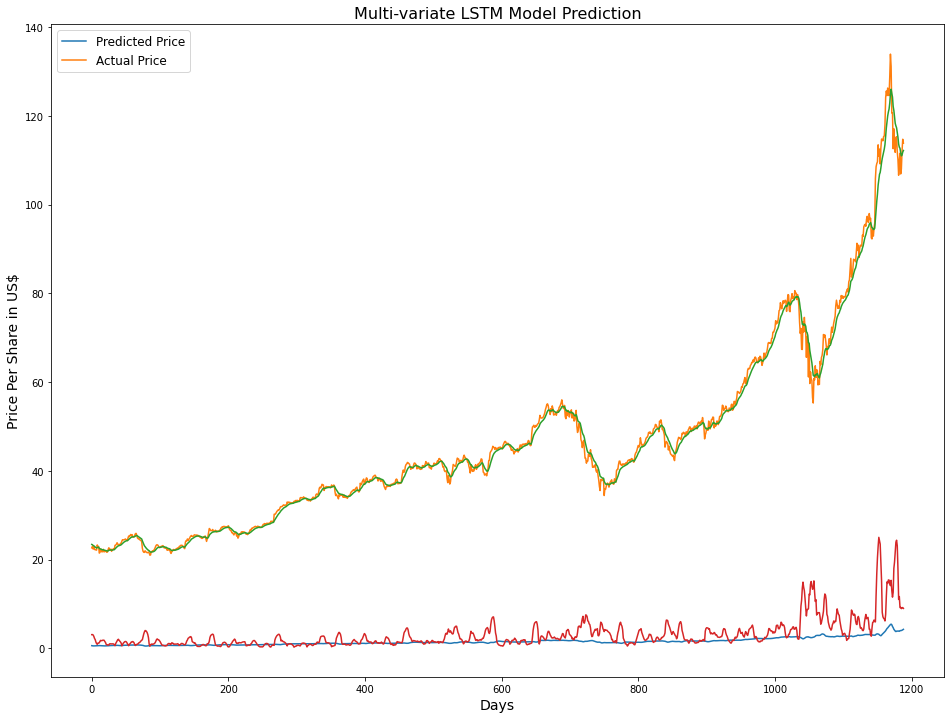

In [314]:
plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax = fig.add_axes([0.1, 0.1, 2.3, 3.5])
plt.xlabel('Days',fontsize='14')
plt.ylabel('Price Per Share in US$',fontsize='14')
plt.title('Multi-variate LSTM Model Prediction',fontsize='16')
pred, = plt.plot([i for i in range(len(hist[4000:])-training_window)], predicted.flatten())
actual, other, three, = plt.plot([i for i in range(len(hist[4000+training_window:]))],hist[4000+training_window:])
plt.legend([pred, actual], ['Predicted Price', 'Actual Price'], loc='upper left', fontsize='large')
plt.show()

In [315]:
from sklearn.metrics import mean_squared_error
mean_squared_error(predicted,y_test)

2458.555146998118